In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

2024-08-30 14:59:17.857496: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 14:59:19.076437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


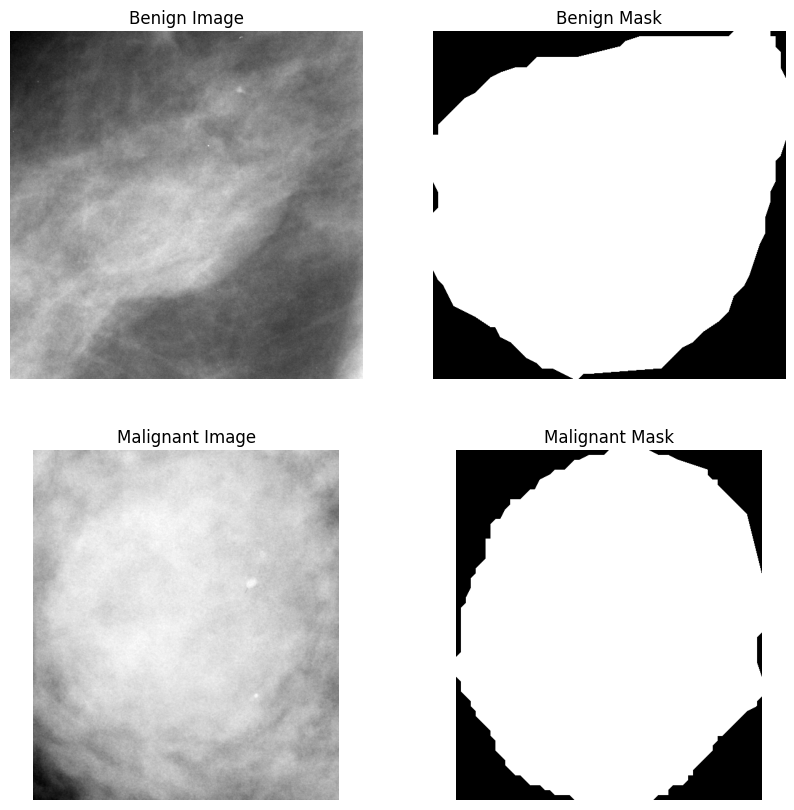

In [2]:
# Define the data directory
data_dir = '/home/ubuntu/BCS/Breast_Cancer_Segmentation/Mass_Data' # change the path of the directory
categories = ['Benign', 'Malignant']

# Function to load and visualize data
def load_and_visualize_data(data_dir, categories):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    for i, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        images = [f for f in os.listdir(category_dir) if f.endswith('.png') and 'MASK' not in f]
        
        img_path = os.path.join(category_dir, images[0])
        mask_path = os.path.join(category_dir, images[0].replace('.png', '_MASK.png'))
        
        image = img_to_array(load_img(img_path, color_mode='grayscale'))
        mask = img_to_array(load_img(mask_path, color_mode='grayscale'))
        
        axes[i, 0].imshow(image.squeeze(), cmap='gray')
        axes[i, 0].set_title(f'{category.capitalize()} Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title(f'{category.capitalize()} Mask')
        axes[i, 1].axis('off')
    
    plt.show()

# Visualize the data
load_and_visualize_data(data_dir, categories)


In [3]:
# Function to get image and mask pairs
def get_image_mask_pairs(data_dir, categories):
    image_paths = []
    mask_paths = []
    
    for category in categories:
        category_dir = os.path.join(data_dir, category)
        images = [f for f in os.listdir(category_dir) if f.endswith('.png') and '_MASK' not in f]
        
        for image in images:
            img_path = os.path.join(category_dir, image)
            mask_path = os.path.join(category_dir, image.replace('.png', '_MASK.png'))
            image_paths.append(img_path)
            mask_paths.append(mask_path)
    
    return np.array(image_paths), np.array(mask_paths)

# Get image and mask pairs
image_paths, mask_paths = get_image_mask_pairs(data_dir, categories)
print(image_paths.shape)
print(mask_paths.shape)

(1961,)
(1961,)


### checkin if the data is balanced 

Class 0.0: 199191885 pixels
Class 255.0: 557626767 pixels


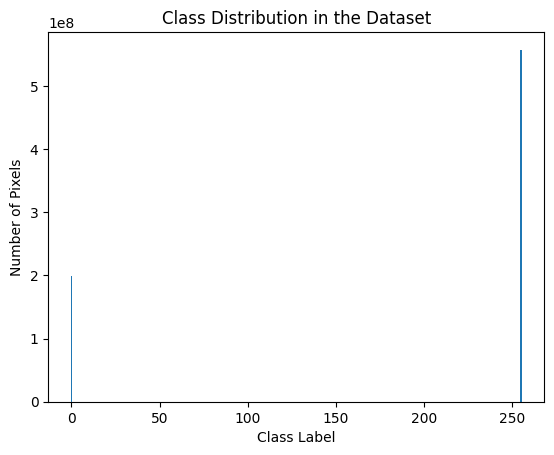

In [4]:
# import numpy as np
# import os
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# import matplotlib.pyplot as plt

# Define the data directory
#mask_paths = [...]  # Assume you have a list of paths to your mask images

# Function to calculate class distribution
def calculate_class_distribution(mask_paths):
    class_counts = {}
    
    for mask_path in mask_paths:
        mask = img_to_array(load_img(mask_path, color_mode='grayscale'))
        unique, counts = np.unique(mask, return_counts=True)
        for u, c in zip(unique, counts):
            if u in class_counts:
                class_counts[u] += c
            else:
                class_counts[u] = c
                
    return class_counts

# Calculate the distribution
class_distribution = calculate_class_distribution(mask_paths)

# Print the distribution
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} pixels")

# Visualize the distribution
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class Label')
plt.ylabel('Number of Pixels')
plt.title('Class Distribution in the Dataset')
plt.show()

Class Imbalance: The dataset is heavily imbalanced, with the majority of pixels belonging to the foreground class (label 255). This can lead to issues during training because the model may become biased towards predicting the foreground class more often, ignoring the background class.

### Split the Data into Train, Validation, and Test Sets

In [4]:
# Split the data
train_img_paths, test_img_paths, train_mask_paths, test_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(train_img_paths, train_mask_paths, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Summary of the splits
print(f"Training set size: {len(train_img_paths)}")
print(f"Validation set size: {len(val_img_paths)}")
print(f"Test set size: {len(test_img_paths)}")

Training set size: 1176
Validation set size: 392
Test set size: 393


Augment the Data

In [5]:
# Data augmentation parameters
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Example of applying augmentation to an image and its mask
def augment_data(img_path, mask_path, image_datagen, mask_datagen, augment_times=5):
    img = img_to_array(load_img(img_path, color_mode='grayscale'))
    mask = img_to_array(load_img(mask_path, color_mode='grayscale'))
    
    img = img.reshape((1,) + img.shape)
    mask = mask.reshape((1,) + mask.shape)
    
    img_gen = image_datagen.flow(img, batch_size=1, seed=42)
    mask_gen = mask_datagen.flow(mask, batch_size=1, seed=42)
    
    img_augmented = []
    mask_augmented = []
    
    for _ in range(augment_times):
        img_augmented.append(img_gen.next()[0])
        mask_augmented.append(mask_gen.next()[0])
    
    return np.array(img_augmented), np.array(mask_augmented)

In [6]:
# Example usage
augment_data(train_img_paths[0], train_mask_paths[0], image_datagen, mask_datagen)

(array([[[[30766.12 ],
          [30744.553],
          [30722.986],
          ...,
          [27906.102],
          [27925.76 ],
          [27874.494]],
 
         [[30138.697],
          [30095.197],
          [30051.697],
          ...,
          [27263.596],
          [27309.904],
          [27415.94 ]],
 
         [[29340.   ],
          [29340.   ],
          [29340.   ],
          ...,
          [26899.254],
          [27010.037],
          [27236.951]],
 
         ...,
 
         [[28095.822],
          [28107.72 ],
          [28105.232],
          ...,
          [28837.617],
          [28594.635],
          [28207.477]],
 
         [[28053.457],
          [28050.97 ],
          [28048.484],
          ...,
          [28844.25 ],
          [28611.986],
          [28223.049]],
 
         [[28116.95 ],
          [28120.293],
          [28123.637],
          ...,
          [28850.885],
          [28629.338],
          [28238.621]]],
 
 
        [[[30091.   ],
          [30091.   ],

### Design a U-Net Model

In [7]:
# U-Net Model Definition
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Contracting Path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Expanding Path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Focal Loss Definition
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        
        # Compute cross-entropy loss
        bce = K.binary_crossentropy(y_true_f, y_pred_f)
        
        # Apply focal loss formula
        bce_exp = K.exp(-bce)
        focal_loss_value = K.mean(alpha * K.pow((1 - bce_exp), gamma) * bce)
        return focal_loss_value
    
    return focal_loss_fixed

# Initialize the model
model = unet_model()

# Compile the model with focal loss
model.compile(optimizer='adam', loss=focal_loss(gamma=2., alpha=0.25), metrics=['accuracy'])


2024-08-30 15:02:22.391540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-30 15:02:22.429062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-30 15:02:22.429346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
# Data Generator
def create_generators(image_paths, mask_paths, batch_size, image_datagen, mask_datagen):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_img_paths = image_paths[i:i + batch_size]
            batch_mask_paths = mask_paths[i:i + batch_size]
            
            img_batch = np.array([img_to_array(load_img(img_path, color_mode='grayscale', target_size=(256, 256))) for img_path in batch_img_paths])
            mask_batch = np.array([img_to_array(load_img(mask_path, color_mode='grayscale', target_size=(256, 256))) for mask_path in batch_mask_paths])
            
            img_batch = img_batch.astype('float32') / 255.0
            mask_batch = mask_batch.astype('float32') / 255.0
            
            img_gen = image_datagen.flow(img_batch, batch_size=batch_size, shuffle=True, seed=42)
            mask_gen = mask_datagen.flow(mask_batch, batch_size=batch_size, shuffle=True, seed=42)
            
            yield next(img_gen), next(mask_gen)

# Generators for training and validation
train_generator = create_generators(train_img_paths, train_mask_paths, 16, image_datagen, mask_datagen)
val_generator = create_generators(val_img_paths, val_mask_paths, 16, image_datagen, mask_datagen)

# Callbacks
checkpoint = ModelCheckpoint('unet_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with focal loss
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_img_paths) // 16,
    validation_data=val_generator,
    validation_steps=len(val_img_paths) // 16,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


2024-08-30 15:02:51.823633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-08-30 15:02:58.283776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8903
2024-08-30 15:03:07.716091: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fbae7b20d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-30 15:03:07.716129: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-08-30 15:03:07.858210: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-30 15:03:08.739747

73/73 [==============================] - ETA: 0s - loss: 2.7316 - accuracy: 0.2826

2024-08-30 15:03:45.130296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


73/73 [==============================] - 62s 485ms/step - loss: 2.7316 - accuracy: 0.2826 - val_loss: 2.7672 - val_accuracy: 0.2764
Epoch 2/50
Epoch 2/50
73/73 [==============================] - 35s 409ms/step - loss: 2.7686 - accuracy: 0.2760 - val_loss: 2.7672 - val_accuracy: 0.2764
Epoch 3/50
73/73 [==============================] - 30s 409ms/step - loss: 2.7680 - accuracy: 0.2761 - val_loss: 2.7672 - val_accuracy: 0.2764
Epoch 4/50
73/73 [==============================] - 30s 410ms/step - loss: 2.7706 - accuracy: 0.2755 - val_loss: 2.7672 - val_accuracy: 0.2764
Epoch 5/50
73/73 [==============================] - 30s 408ms/step - loss: 2.7691 - accuracy: 0.2759 - val_loss: 2.7672 - val_accuracy: 0.2764
Epoch 6/50
73/73 [==============================] - 30s 411ms/step - loss: 2.7692 - accuracy: 0.2758 - val_loss: 2.7672 - val_accuracy: 0.2764
Epoch 7/50
73/73 [==============================] - 30s 409ms/step - loss: 2.7693 - accuracy: 0.2758 - val_loss: 2.7672 - val_accuracy: 0.2764

### Train the Model

### Visualize the Model Performance

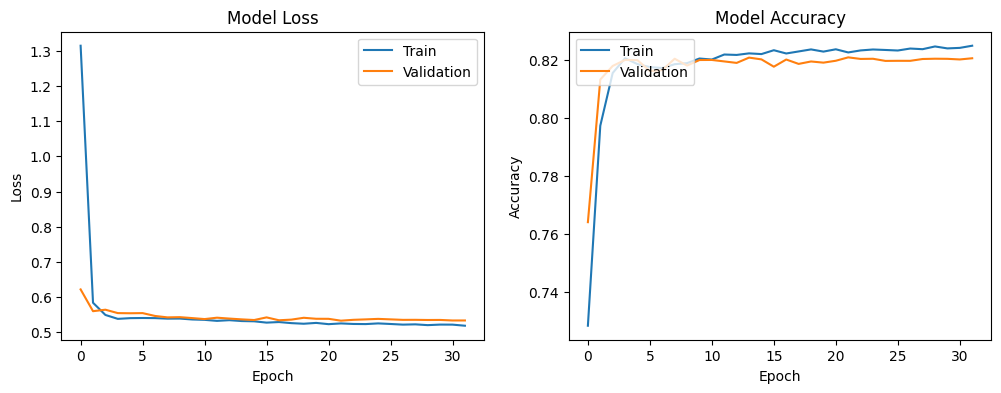

In [ ]:
# Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

# Visualize the performance
plot_training_history(history)


### Model Loss:
- Initial High Loss: The training loss starts very high initially (around 10) and quickly drops to near zero within a few epochs. This is a common pattern where the model starts with poor performance and quickly adjusts its weights to reduce the loss during the early stages of training.
- Stabilized Loss: After the initial drop, both the training and validation losses stabilize at very low values and remain consistent throughout the remaining epochs.
- Conclusion: The model is learning and fitting the data very well, as indicated by the consistently low loss values. However, such low loss values could indicate that the model might be overfitting, especially if the validation loss doesn't match the training loss.
### Model Accuracy:
- Initial Increase in Accuracy: The training and validation accuracies start at around 73% and rapidly increase to above 82% within the first 10-20 epochs.
- Validation Accuracy Drop: There is a significant drop in validation accuracy around epoch 40, followed by recovery. This could indicate some instability in the model or possibly some noise or outliers in the validation set that the model struggles to handle.
- Consistency in Accuracy: After the drop, both training and validation accuracies remain relatively stable, hovering around 82-83%. The training accuracy continues to slightly increase, while the validation accuracy fluctuates more.
- Conclusion: The model achieves relatively high accuracy, but the drop in validation accuracy suggests there may be some overfitting or challenges with generalization. The validation accuracy is fairly close to the training accuracy, which is a positive sign, but the fluctuation indicates some instability in performance on unseen data.

### Test the Model Performance on the Test Set

In [ ]:
# Evaluation Metrics
def calculate_metrics(y_true, y_pred, threshold=0.5, average='binary'):
    y_pred_binary = (y_pred > threshold).astype(int)
    
    dice = 2 * np.sum(y_true * y_pred_binary) / (np.sum(y_true) + np.sum(y_pred_binary))
    iou = jaccard_score(y_true.flatten(), y_pred_binary.flatten(), average=average)
    precision = precision_score(y_true.flatten(), y_pred_binary.flatten(), average=average)
    recall = recall_score(y_true.flatten(), y_pred_binary.flatten(), average=average)
    f1 = f1_score(y_true.flatten(), y_pred_binary.flatten(), average=average)
    
    return dice, iou, precision, recall, f1

# Evaluate the model on the test set
def evaluate_model_on_test_set(model, test_img_paths, test_mask_paths):
    y_true = []
    y_pred = []
    
    for img_path, mask_path in zip(test_img_paths, test_mask_paths):
        img = img_to_array(load_img(img_path, color_mode='grayscale', target_size=(256, 256)))
        mask = img_to_array(load_img(mask_path, color_mode='grayscale', target_size=(256, 256)))
        
        img = img.reshape((1,) + img.shape)
        pred_mask = model.predict(img)
        pred_mask = (pred_mask > 0.5).astype(int)
        
        y_true.append(mask.flatten())
        y_pred.append(pred_mask.flatten())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    dice, iou, precision, recall, f1 = calculate_metrics(y_true, y_pred)
    
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    print(f'Accuracy on the test set: {accuracy * 100:.2f}%')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Dice Coefficient: {dice:.4f}')
    print(f'IoU: {iou:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

# Run evaluation
evaluate_model_on_test_set(model, test_img_paths, test_mask_paths)

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


/opt/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on the test set: 11.14%
Confusion Matrix:
[[ 2869994  3839546        0]
 [       0        0        0]
 [  343931 18702177        0]]
Dice Coefficient: 1.9548
IoU: 0.1060
Precision: 0.2326
Recall: 0.1114
F1 Score: 0.1507


1/1 [==============================] - 0s 22ms/step


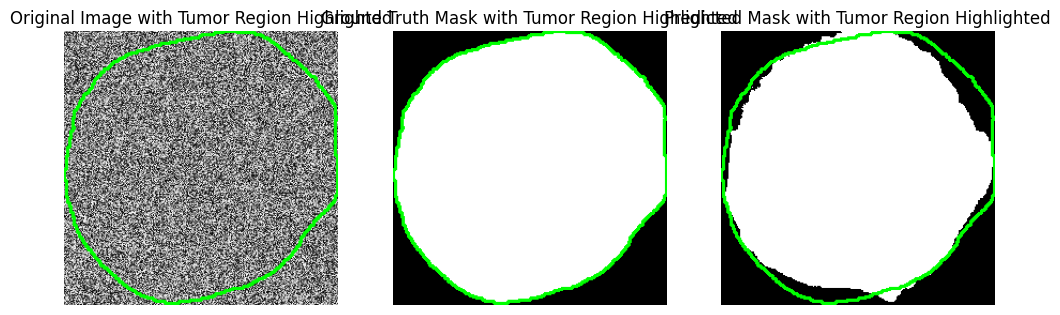

1/1 [==============================] - 0s 23ms/step


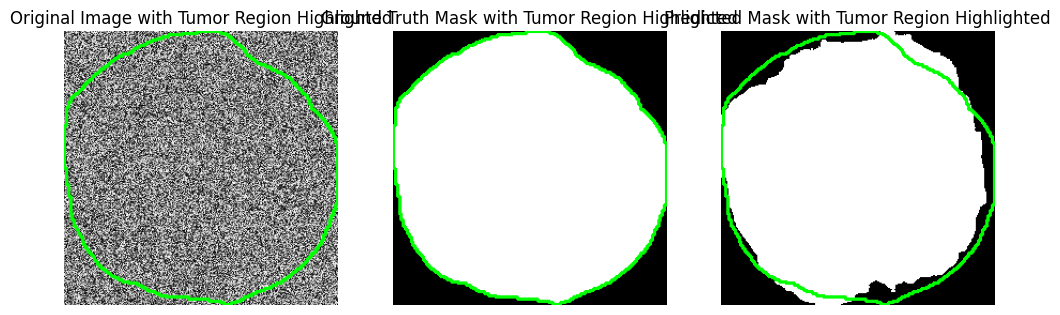

1/1 [==============================] - 0s 23ms/step


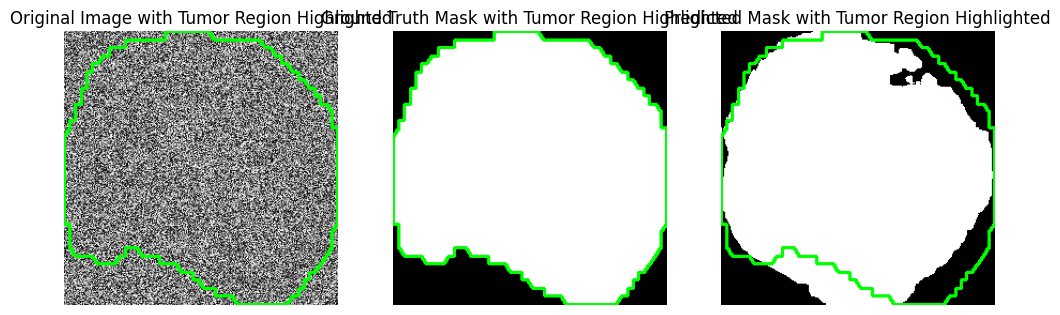

1/1 [==============================] - 0s 22ms/step


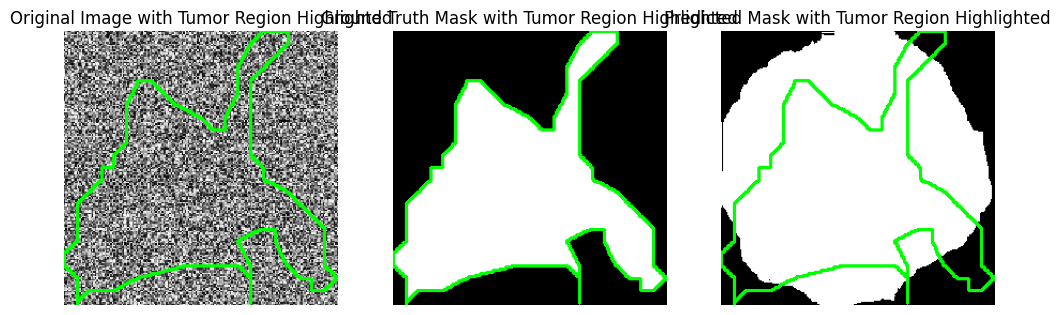

1/1 [==============================] - 0s 22ms/step


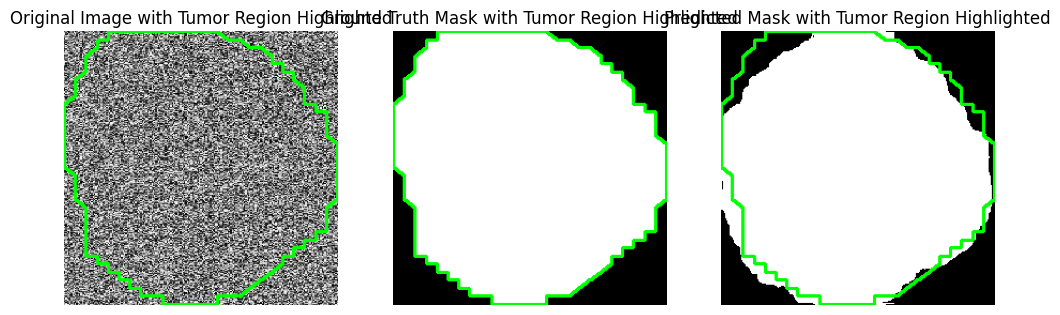

In [ ]:
# Visualize Predictions
def visualize_predictions(model, test_img_paths, test_mask_paths, num_samples=5):
    """
    Visualizes the test images, ground truth masks, and predicted masks.
    
    Parameters:
    - model: Trained U-Net model.
    - test_img_paths: List of paths to test images.
    - test_mask_paths: List of paths to ground truth masks for the test images.
    - num_samples: Number of samples to visualize.
    """
    for i in range(num_samples):
        # Load and preprocess the test image and its corresponding mask
        img_path = test_img_paths[i]
        mask_path = test_mask_paths[i]
        
        img = img_to_array(load_img(img_path, color_mode='grayscale', target_size=(256, 256))) / 255.0
        mask = img_to_array(load_img(mask_path, color_mode='grayscale', target_size=(256, 256))) / 255.0
        
        # Predict the mask
        pred_mask = model.predict(img.reshape(1, 256, 256, 1))
        pred_mask = (pred_mask > 0.5).astype(int).reshape(256, 256)
        
        # Plot the image, ground truth mask, and predicted mask
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title('Test Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.show()

# Example usage:
visualize_predictions(model, test_img_paths, test_mask_paths, num_samples=5)

In [ ]:
# Visualize Predictions
def visualize_predictions(model, test_img_paths, test_mask_paths, num_samples=5):
    """
    Visualizes the test images, ground truth masks, and predicted masks.
    
    Parameters:
    - model: Trained U-Net model.
    - test_img_paths: List of paths to test images.
    - test_mask_paths: List of paths to ground truth masks for the test images.
    - num_samples: Number of samples to visualize.
    """
    for i in range(num_samples):
        # Load and preprocess the test image and its corresponding mask
        img_path = test_img_paths[i]
        mask_path = test_mask_paths[i]
        
        img = img_to_array(load_img(img_path, color_mode='grayscale', target_size=(256, 256))) / 255.0
        mask = img_to_array(load_img(mask_path, color_mode='grayscale', target_size=(256, 256))) / 255.0
        
        # Predict the mask
        pred_mask = model.predict(img.reshape(1, 256, 256, 1))
        pred_mask = (pred_mask > 0.5).astype(int).reshape(256, 256)
        
        # Plot the image, ground truth mask, and predicted mask
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title('Test Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.show()

# Example usage:
visualize_predictions(model, test_img_paths, test_mask_paths, num_samples=5)